# Fine-Tuning BERT for Sentence-Pair Classification

This notebook demonstrates how to fine-tune BERT-based models for the sentence-pair classification task. Utilizing the Hugging Face transformers and datasets libraries, this TensorFlow implementation enables seamless research experiments and evaluation metrics.

The sentence-pair classification task is a vital component of the semantic textual similarity/duplicate problem. It involves two pairs of questions, and the goal is to model the textual interaction between them.

## Dataset

The dataset used in this notebook is the Quora Question Pair (QQP) dataset, which is a part of the GLUE benchmark. The dataset consists of pairs of questions, and the objective is to predict whether one sentence is the paraphrase of the other. The evaluation metrics for this task are F1 score and accuracy.

## Main Features

This tutorial offers the following main features:

1. End-to-end ML implementation covering training, validation, prediction, and evaluation.
2. Capability to utilize custom datasets for fine-tuning.
3. Facilitation of quick experiments with other BERT-based models such as BERT, ALBERT, and more.
4. A comparison between the fine-tuned model and the model without fine-tuning.

In [1]:
# checking tenserflow gpu
import tensorflow as tf
tf.test.gpu_device_name()

2023-07-19 08:06:21.151579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-19 08:06:21.169468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-19 08:06:21.169534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-19 08:06:21.775059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-19 08:06:21.775127: I tensorflow/compile

'/device:GPU:0'

In [2]:
# checking pytorch gpu
import torch
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Importing libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
plt.style.use('ggplot')
# os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [4]:
# Reading the data
train_df = pd.read_csv("train.csv.zip")
train_df.shape

(404290, 6)

In [5]:
# Printing the first 5 rows
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
# Information about dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
# checking for null values
train_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
# Removing null values
train_df.dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [9]:
# removing unnecessary columns
train_df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)
train_df.sample(5)

,question1,question2,is_duplicate
88485,"For the CAT preparation, which is the best ins...",What is the best coaching institute for CAT pr...,1
111700,How do I start up a new cafe?,What's the best strategy to start up a cafe?,1
126774,Why do we use abbreviations?,Why do we like to use abbreviations so much?,1
194997,Is Hillary Clinton crooked?,Why is Hillary Clinton so corrupt?,1
152810,How many times in a day a women need sex?,How many times a woman have sex in a day?,1


### Converting data to HuggingFace Dataset

In [10]:
# Splitting the data into train and validation set
train_data, test_val_data = train_test_split(train_df, test_size=0.4, random_state=100, shuffle=True)
val_data, test_data = train_test_split(test_val_data, test_size=0.5, random_state=100, shuffle=True)
train_data.to_csv('train_clean.csv',index=False)
val_data.to_csv('val_clean.csv',index=False)
test_data.to_csv('test_clean.csv',index=False)

In [11]:
# Convert the data into Hugging Face Dataset format
dataset = load_dataset('csv', data_files={'train': 'train_clean.csv','valid':'val_clean.csv',})
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-ee7343318a037f09/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 242572
    })
    valid: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 80857
    })
})

In [12]:
# Model set and batch size
model_checkpoint = "distilbert-base-uncased"
batch_size = 56

In [13]:
# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Testing Tokenizer

In [14]:
# Running tokenizer on sample data
tokenizer(train_df.question1[0], train_df.question2[0],padding='max_length', truncation=True, max_length=128, return_tensors='tf')  

2023-07-19 08:06:27.600734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-19 08:06:27.600840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-19 08:06:27.600876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-19 08:06:27.601141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-19 08:06:27.601174: I tensorflow/compile

{'input_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  2054,  2003,  1996,  3357,  2011,  3357,  5009,  2000,
        15697,  1999,  3745,  3006,  1999,  2634,  1029,   102,  2054,
         2003,  1996,  3357,  2011,  3357,  5009,  2000, 15697,  1999,
         3745,  3006,  1029,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

### Tokenizer for data preprocessing

In [15]:
# function to tokenize the data
def preprocess_function(records):
    return tokenizer(records['question1'], records['question2'], truncation=True, max_length = 128)

In [16]:
# Running tokenizer on dataset
encoded_dataset = dataset.map(preprocess_function, batched=True, )

Map:   0%|          | 0/242572 [00:00<?, ? examples/s]

Map:   0%|          | 0/80857 [00:00<?, ? examples/s]

In [17]:
# Preprocessed dataset
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'input_ids', 'attention_mask'],
        num_rows: 242572
    })
    valid: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'input_ids', 'attention_mask'],
        num_rows: 80857
    })
})

In [18]:
# Columns added by tokenizer
col_tokenizer = encoded_dataset.column_names['train'][3:]
col_tokenizer

['input_ids', 'attention_mask']

### Data padding and batching

In [19]:
# Adding Padding to the dataset
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf",)

In [20]:
# Making the dataset batched and shuffled
tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=col_tokenizer,
    label_cols=["is_duplicate"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["valid"].to_tf_dataset(
    columns=col_tokenizer,
    label_cols=["is_duplicate"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [21]:
# sample train batch
sample_batch=next(iter(tf_train_dataset))
sample_batch

({'input_ids': <tf.Tensor: shape=(56, 83), dtype=int64, numpy=
  array([[ 101, 2129, 2116, ...,    0,    0,    0],
         [ 101, 2054, 2003, ...,    0,    0,    0],
         [ 101, 2429, 2000, ...,    0,    0,    0],
         ...,
         [ 101, 2040, 2003, ...,    0,    0,    0],
         [ 101, 2054, 4084, ...,    0,    0,    0],
         [ 101, 2054, 1005, ...,    0,    0,    0]])>,
  'attention_mask': <tf.Tensor: shape=(56, 83), dtype=int64, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>},
 <tf.Tensor: shape=(56,), dtype=int64, numpy=
 array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0])>)

In [22]:
# sample decoded string
tokenizer.decode(sample_batch[0]['input_ids'][0])

'[CLS] how many businesses does warren buffett own? [SEP] what companies does warren buffett own? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [23]:
# Percentage of classes in dataset
num_classes = len(train_df.is_duplicate.unique())
round(train_df.is_duplicate.value_counts(normalize=True)*100,2)

0    63.08
1    36.92
Name: is_duplicate, dtype: float64

### Loading the model checkpoint

In [24]:
# Downloading the model
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_classes)

2023-07-19 08:06:37.542752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceCla

### Defining the parameters, optimizer and loss function

In [25]:
# Setting epochs and learning rate
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

In [26]:
# Optimizer and loss function
opt = Adam(learning_rate=lr_scheduler)
loss = SparseCategoricalCrossentropy(from_logits=True)

### Plotting the learning rate decay

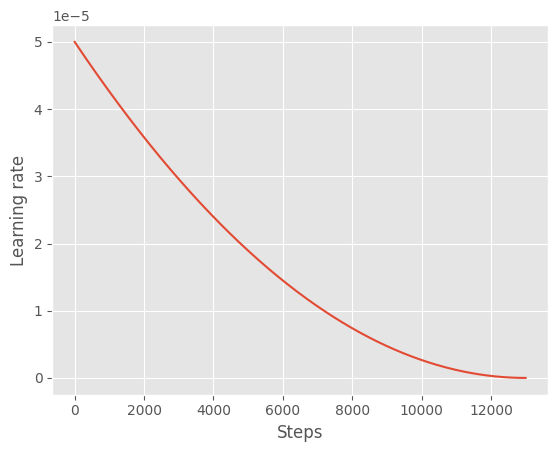

In [27]:
# Plotting the learning rate
plt.plot([lr_scheduler(step).numpy() for step in range(num_train_steps)])
plt.xlabel("Steps")
plt.ylabel("Learning rate")
plt.show()

In [28]:
# Compiling the model
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [29]:
# Training the model
history=model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs)

Epoch 1/3
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-07-19 08:07:07.225876: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x555bbfdab390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-19 08:07:07.225935: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-07-19 08:07:07.233988: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-19 08:07:07.334465: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4332/4332 [==============================] - 896s 204ms/step - loss: 0.3277 - accuracy: 0.8497 - val_loss: 0.2642 - val_accuracy: 0.8849
Epoch 2/3
4332/4332 [==============================] - 877s 202ms/step - loss: 0.2016 - accuracy: 0.9165 - val_loss: 0.2549 - val_accuracy: 0.8929
Epoch 3/3
4332/4332 [==============================] - 881s 203ms/step - loss: 0.1388 - accuracy: 0.9456 - val_loss: 0.2843 - val_accuracy: 0.8938


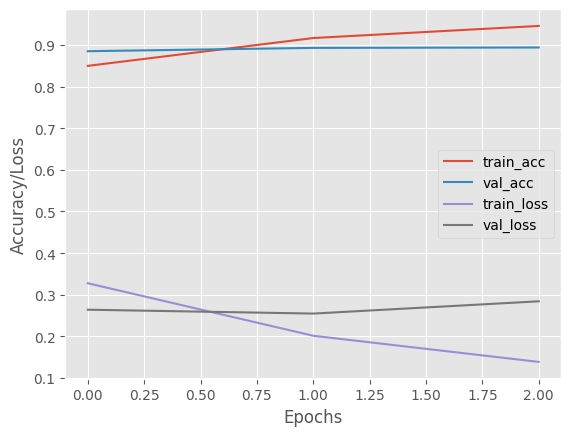

In [30]:
# Plotting the accuracy, training and validation loss 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'])
plt.show()

In [31]:
# Saving the model
model.save_pretrained(f"saved_model_epoch{num_epochs}")

In [32]:
# Loading the Last saved model
trained_model = TFAutoModelForSequenceClassification.from_pretrained(f'saved_model_epoch{num_epochs}',num_labels = num_classes)

Some layers from the model checkpoint at saved_model_epoch3 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_epoch3 and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Function to check similarity
def check_similarity(question1, question2, debug = 0):
  tokenizer_output = tokenizer(question1, question2, truncation=True, max_length = 128, return_tensors = 'tf')
  logits = trained_model(**tokenizer_output)["logits"]
  predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
  if predicted_class_id == 1:
    if(debug):
        print("Both questions mean the same")
    return 1
  else:
    if(debug):
        print("Both the questions are different.")
    return 0


In [34]:
# Checking similarity between two questions
check_similarity("Why are people so obsessed with cricket?", "Why are people so obsessed with football?", 1)

Both the questions are different.


0

In [35]:
# Checking similarity between two questions
check_similarity("Why are people so obsessed with cricket?", "Why do people like cricket?", 1)

Both questions mean the same


1

### Testing the model on validation set and test set

In [36]:
import swifter

In [37]:
# checking accuracy on test data
val_df = pd.read_csv("val_clean.csv").sample(1000)
val_df['predicted'] = val_df.swifter.apply(lambda row: check_similarity(row['question1'], row['question2']), axis=1)

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
# checking metrics on test data
val_df['predicted'] = val_df['predicted'].astype(int)
val_df['is_duplicate'] = val_df['is_duplicate'].astype(int)
print("Accuracy on Validation data is ",round(accuracy_score(val_df['is_duplicate'],val_df['predicted'])*100,2))
print("Precision on Validation data is ",round(precision_score(val_df['is_duplicate'],val_df['predicted'])*100,2))
print("Recall on Validation data is ",round(recall_score(val_df['is_duplicate'],val_df['predicted'])*100,2))
print("F1 score on Validation data is ",round(f1_score(val_df['is_duplicate'],val_df['predicted'])*100,2))
print("ROC AUC score on Validation data is ",round(roc_auc_score(val_df['is_duplicate'],val_df['predicted'])*100,2))

Accuracy on Validation data is  88.9
Precision on Validation data is  84.72
Recall on Validation data is  85.41
F1 score on Validation data is  85.06
ROC AUC score on Validation data is  88.18


In [39]:
# checking accuracy on test data
test_df = pd.read_csv("test_clean.csv").sample(1000)
test_df['predicted'] = test_df.swifter.apply(lambda row: check_similarity(row['question1'], row['question2']), axis=1)

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
# checking metrics on test data
test_df['predicted'] = test_df['predicted'].astype(int)
test_df['is_duplicate'] = test_df['is_duplicate'].astype(int)
print("Accuracy on test data is ",round(accuracy_score(test_df['is_duplicate'],test_df['predicted'])*100,2))
print("Precision on test data is ",round(precision_score(test_df['is_duplicate'],test_df['predicted'])*100,2))
print("Recall on test data is ",round(recall_score(test_df['is_duplicate'],test_df['predicted'])*100,2))
print("F1 score on test data is ",round(f1_score(test_df['is_duplicate'],test_df['predicted'])*100,2))
print("ROC AUC score on test data is ",round(roc_auc_score(test_df['is_duplicate'],test_df['predicted'])*100,2))

Accuracy on test data is  89.2
Precision on test data is  84.56
Recall on test data is  87.66
F1 score on test data is  86.08
ROC AUC score on test data is  88.9
